In [28]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
%matplotlib inline

In [56]:
secretnum = '101'
#secretnum = str(bin(4))
print(secretnum)

101


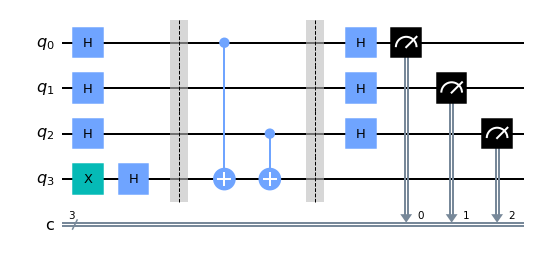

In [143]:
circuit = QuantumCircuit(len(secretnum)+1, len(secretnum))
# Oracle
circuit.h(range(len(secretnum)))
circuit.x(len(secretnum))
circuit.h(len(secretnum))
circuit.barrier()

# Build secret box, a cx gate means the secret value is a 1 and it goes left to right from down to up
for x, yesno in enumerate(reversed(secretnum)):
    if yesno == '1':
        circuit.cx(x, len(secretnum))
circuit.barrier()

#Fourier sampling - basically a reverse hadamard transform
circuit.h(range(len(secretnum)))

# Measuring circuit
circuit.measure(range(len(secretnum)),range(len(secretnum)))

circuit.draw(output='mpl')

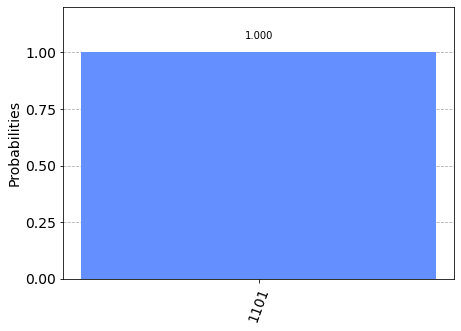

In [138]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend=simulator, shots=1).result()
counts = result.get_counts()

plot_histogram(counts)

In [141]:
# CONVERT COUNTS DICT TO INT DECIMAL
binval = 0
for num in counts:
    if num == '0' or '1':
        binval = num

intval = 0 
for x, yesno in enumerate(reversed(binval)):
    if yesno == '1':
        intval += 2 ** x
print(intval)

TypeError: 'int' object is not reversible

In [60]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_santiago')

from qiskit.tools.monitor import job_monitor

ibmqfactory.load_account:WARNING:2020-11-14 20:30:36,645: Credentials are already in use. The existing account in the session will be replaced.


In [61]:
job = execute(circuit, backend=device, shots=1024)
job_monitor(job)

Job Status: job has successfully run


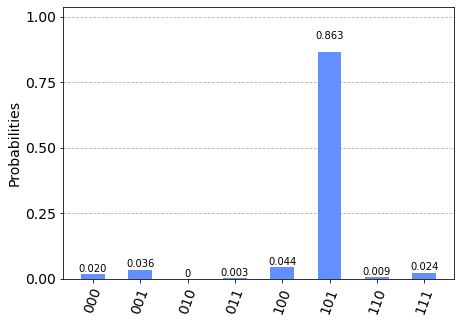

In [94]:
results = job.result()
counts = results.get_counts()
plot_histogram(counts)

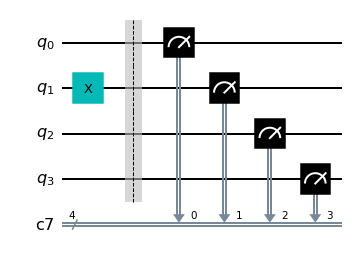

In [103]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr  = circuit.qregs[0], circlabel='measerrormitigationcal')
# Let's draw an arbitrary calibration circuit to look at an example
cal_circuits[2].draw(output= 'mpl')

In [96]:
len(cal_circuits)

16

In [97]:
cal_job = execute(cal_circuits,
                  backend=device,
                  shots=1024,
                  optimization_level=0,
                  )
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

5fb089373bdc340012e650fd
Job Status: job has successfully run


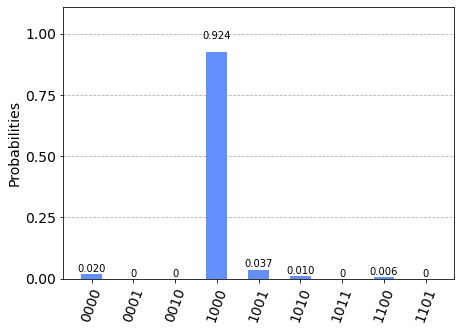

In [98]:
# Visualizing counts of an arbitrary calibration circuit
# Notice that we only measure the basis state 75-85% of the time, theoretically it should be 100%
plot_histogram(cal_results.get_counts(cal_circuits[8]))

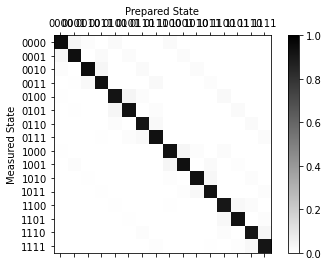

In [99]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_fitter.plot_calibration()

In [100]:
meas_filter = meas_fitter.filter
mitigated_result = meas_filter.apply(results)

QiskitError: "Unexpected state label '000', verify the fitter's state labels correpsond to the input data"

In [ ]:
device_counts = device_results.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], legend=['device, noisy', 'device, mitigated'])

In [ ]:
device_mitigated_counts_2 = meas_filter.apply(counts)
plot_histogram(counts)